In [1]:
import os.path
from typing import Any, Callable, List, Optional, Tuple

from PIL import Image
from torchvision.datasets import VisionDataset
import numpy as np
import matplotlib.pyplot as plt

import torch

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
torch.cuda.device_count()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
class CocoDetection(VisionDataset):
    def __init__(
        self,
        l,
        mean: List,
        std: List,
        root: str,
        annFile: str,
        binary_segmentation: bool,
        class_names: Optional[List] = None,
        transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transforms, transform)
        from pycocotools.coco import COCO

        self.l = l
        self.get_mask = (
            self._get_binary_mask if binary_segmentation else self._get_semantic_mask
        )
        self.coco = COCO(annFile)

        if class_names is not None:
            cat_ids = self._get_category_ids_from_name(category_names=class_names)
            self.ids = list(
                sorted((self._get_img_ids_for_category_ids(category_ids=cat_ids)))
            )

        else:
            cat_ids = self.coco.getCatIds()
            self.ids = list(sorted(self.coco.imgs.keys()))

        self.cat2idx = {cat_id: idx + 1 for idx, cat_id in enumerate(cat_ids)}
        self.cat2idx[0] = 0

        self.mean = torch.tensor(mean).reshape(len(mean), 1, 1)
        self.std = torch.tensor(std).reshape(len(std), 1, 1)

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")

    def _load_target(self, id: int) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        mask = self._load_target(id)

        mask = self.get_mask(image, mask)
        mask = (mask != 0).astype(float)

        if self.transform is not None:
            augmented = self.transform(image=np.array(image), mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        #         if self.target_transform is not None:
        #             mask = self.target_transform(image=mask)["image"]

        return image, mask

    def __len__(self) -> int:
        # return len(self.ids)
        return self.l

    def _get_all_classes(self):
        catIDs = self.coco.getCatIds()
        return self.coco.loadCats(catIDs)

    def _get_category_info_from_ids(self, ids: list):
        all_cat = self._get_all_classes()
        return [category for category in all_cat if category["id"] in ids]

    def _get_category_ids_from_name(self, category_names: list):
        return self.coco.getCatIds(catNms=category_names)

    def _get_img_ids_for_category_ids(self, category_ids: list):
        img_ids = []

        for catIds in category_ids:
            img_ids.extend(self.coco.getImgIds(catIds=catIds))

        return img_ids

    def _get_img_ids_for_category_names(self, category_names: list):
        img_ids = []
        category_ids = self._get_category_ids_from_name(category_names=class_names)

        for catIds in category_ids:
            img_ids.extend(self.coco.getImgIds(catIds=catIds))

        return img_ids

    def _get_all_category_ids_in_img_id(self, img_id: int) -> List:
        target = self._load_target(img_id)
        return list({annotation["category_id"] for annotation in target})

    def _get_binary_mask(self, image: Image, annotations: List) -> np.array:
        w, h = image.size
        mask = np.zeros((h, w))

        for annotation in annotations:
            category_id = annotation["category_id"]

            if category_id in self.cat2idx:
                pixel_value = self.cat2idx[category_id]
                mask = np.maximum(self.coco.annToMask(annotation) * pixel_value, mask)

        return mask

    def _get_semantic_mask(self, image: Image, annotations: List) -> np.array:
        w, h = image.size
        mask = np.zeros((len(self.cat2idx), h, w))

        for annotation in annotations:
            category_id = annotation["category_id"]

            if category_id in self.cat2idx:
                pixel_value = self.cat2idx[category_id]
                mask[pixel_value] = np.maximum(
                    self.coco.annToMask(annotation), mask[pixel_value]
                )

        # [h, w, channels]
        mask = np.transpose(mask, (1, 2, 0))
        return mask

    def _plot_image_and_mask(self, index, figsize=(7, 3)):
        image, mask = self[index]

        # denormalise image
        image = image * self.std + self.mean

        # give unique pixel value to each class
        if len(mask.shape) == 3:
            mask *= torch.arange(255 - mask.shape[0], 255).reshape(-1, 1, 1)
            mask = mask.sum(0, keepdim=True).permute(1, 2, 0)

        # Create a figure with two subplots side by side
        fig, axs = plt.subplots(1, 2, figsize=figsize)

        axs[0].imshow(image.permute(1, 2, 0))
        axs[0].set_title("Image")

        axs[1].imshow(mask)
        axs[1].set_title("Mask")

        plt.show()

In [4]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

# imagenet mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224
scale = 1


train_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * scale),
            min_width=int(IMAGE_SIZE * scale),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.Rotate(limit=10, interpolation=1, border_mode=4),
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.OneOf(
            [
                A.ShiftScaleRotate(
                    rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT
                ),
                # A.Affine(shear=15, p=0.5, mode="constant"),
            ],
            p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
        A.Normalize(
            mean=mean,
            std=std,
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ],
)

test_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(
            mean=mean,
            std=std,
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ]
)

In [5]:
train_dataset = CocoDetection(
    l=100000,
    mean=mean,
    std=std,
    root="./data/train/data",
    annFile="./data/raw/instances_train2017.json",
    transform=train_transform,
    binary_segmentation=True,
)

test_dataset = CocoDetection(
    l=1000,
    mean=mean,
    std=std,
    root="./data/validation/data",
    annFile="./data/raw/instances_val2017.json",
    transform=test_transform,
    binary_segmentation=True,
)

loading annotations into memory...
Done (t=21.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.76s)
creating index...
index created!


In [6]:
img_idx = 15

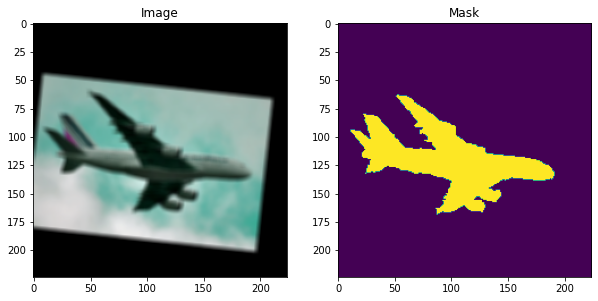

In [7]:
train_dataset._plot_image_and_mask(img_idx, figsize=(10, 5))

In [8]:
img, mask = train_dataset[img_idx]
img.shape, type(img), mask.shape, type(mask)

(torch.Size([3, 224, 224]), torch.Tensor, torch.Size([224, 224]), torch.Tensor)

In [9]:
(100 * mask.sum() / mask.numel()).item()

13.243383290816327

In [10]:
cat_ids = train_dataset._get_all_category_ids_in_img_id(train_dataset.ids[img_idx])
cat_ids

[5]

In [11]:
train_dataset._get_category_info_from_ids(cat_ids)

[{'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}]

# Download Dataset

In [12]:
# # download Coco dataset
# import fiftyone.zoo as foz


# foz.load_zoo_dataset(
#     "coco-2017",
#     split="train",
#     label_types=["segmentations"],
#     max_samples=10000,
#     dataset_dir="./data",
# )

# foz.load_zoo_dataset(
#     "coco-2017",
#     split="validation",
#     label_types=["segmentations"],
#     max_samples=1000,
#     dataset_dir="./data",
# )

# DataLoader

In [13]:
import os

num_workers = int(0.8 * os.cpu_count())

In [14]:
# dataloaders
BATCH_SIZE = 16

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers
)

# Model

In [15]:
import yaml
from unet import UNet
from easydict import EasyDict
from torchinfo import summary

from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

### MODEL 1

In [16]:
# config_path = './custom_config.yml'

# with open(config_path, 'r') as file:
#     yaml_data = yaml.safe_load(file)

# config = EasyDict(yaml_data)

# model = UNet(config["encoder_config"], config["decoder_config"], nclasses=1).to(device)

# summary(
#     model,
#     input_data=torch.rand((1, 3, 512, 512)),
#     device=device
# )

### MODEL 2

In [17]:
config_path = "./resnet_config.yml"

with open(config_path, "r") as file:
    yaml_data = yaml.safe_load(file)

config = EasyDict(yaml_data)


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        for param in resnet.parameters():
            param.requires_grad_(False)

        self.stages = nn.ModuleDict(
            {
                "block1": nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu),
                "block2": nn.Sequential(resnet.maxpool, resnet.layer1),
                "block3": resnet.layer2,
                "block4": resnet.layer3,
                "block5": resnet.layer4,
            }
        )

    def forward(self, x):
        stages = {}

        for name, stage in self.stages.items():
            x = stage(x)
            stages[name] = x

        return x, stages


class DecoderLayer(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=2, stride=2, padding=[0, 0]
    ):
        super(DecoderLayer, self).__init__()
        self.up_conv = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=in_channels // 2,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding[0],
        )

        self.bn1 = nn.BatchNorm2d(in_channels)

        self.conv = nn.Sequential(
            *[
                self._conv_relu_layer(
                    in_channels=in_channels if i == 0 else out_channels,
                    out_channels=out_channels,
                    padding=padding[1],
                )
                for i in range(2)
            ]
        )

    def _conv_relu_layer(self, in_channels, out_channels, padding=0):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=padding,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )

    @staticmethod
    def crop_cat(x, encoder_output):
        delta = (encoder_output.shape[-1] - x.shape[-1]) // 2
        encoder_output = encoder_output[
            :, :, delta : delta + x.shape[-1], delta : delta + x.shape[-1]
        ]
        return torch.cat((encoder_output, x), dim=1)

    def forward(self, x, encoder_output):
        x = self.up_conv(x)
        x = self.crop_cat(x, encoder_output)
        x = self.bn1(x)
        return self.conv(x)


class Decoder(nn.Module):
    def __init__(self, config):
        super(Decoder, self).__init__()
        self.decoder = nn.ModuleDict(
            {
                name: DecoderLayer(
                    in_channels=block["in_channels"],
                    out_channels=block["out_channels"],
                    kernel_size=block["kernel_size"],
                    stride=block["stride"],
                    padding=block["padding"],
                )
                for name, block in config.items()
            }
        )

    def forward(self, x, encoder_output):
        for name, block in self.decoder.items():
            x = block(x, encoder_output[name])

        return x


class UNet(nn.Module):
    def __init__(self, decoder_config, nclasses):
        super(UNet, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(config=decoder_config)

        self.output = nn.Sequential(
            nn.Conv2d(
                in_channels=decoder_config["block1"]["out_channels"],
                out_channels=nclasses,
                kernel_size=1,
            ),
            nn.UpsamplingBilinear2d(size=224),
        )

    def forward(self, x):
        x, encoder_step_output = self.encoder(x)
        x = self.decoder(x, encoder_step_output)
        x = self.output(x)
        return x


model = UNet(config["decoder_config"], nclasses=1).to(device)

summary(model, input_data=torch.rand((1, 3, 224, 224)), device=device)

Layer (type:depth-idx)                                  Output Shape              Param #
UNet                                                    [1, 1, 224, 224]          --
├─Encoder: 1-1                                          [1, 2048, 7, 7]           --
│    └─ModuleDict: 2-1                                  --                        --
│    │    └─Sequential: 3-1                             [1, 64, 112, 112]         (9,536)
│    │    └─Sequential: 3-2                             [1, 256, 56, 56]          (215,808)
│    │    └─Sequential: 3-3                             [1, 512, 28, 28]          (1,219,584)
│    │    └─Sequential: 3-4                             [1, 1024, 14, 14]         (7,098,368)
│    │    └─Sequential: 3-5                             [1, 2048, 7, 7]           (14,964,736)
├─Decoder: 1-2                                          [1, 64, 52, 52]           --
│    └─ModuleDict: 2-2                                  --                        --
│    │    └─DecoderL

### MODEL 3

In [18]:
# import segmentation_models_pytorch as smp
# import torch

# model = smp.create_model(
#             "FPN",encoder_name="resnet34", in_channels=3, classes=1,
#         )

# summary(
#     model,
#     input_data=torch.rand((1, 3, 224, 224)),
#     device=device
# )

In [19]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {total_params - trainable_params}")

Total parameters: 70807873
Trainable parameters: 47299841
Non-trainable parameters: 23508032


In [20]:
# import torch.optim as optim
# import torch.nn as nn
# import segmentation_models_pytorch as smp


# class Loss(nn.Module):
#     def __init__(self):
#         super(Loss, self).__init__()
#         self.dice_criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
#         self.class_criterion = nn.BCEWithLogitsLoss()

#         self.lambda_dice = 1
#         self.lambda_class = 1

#     def forward(self, prediction, target):
#         """
#         prediction = [batch, 1, 224, 224]
#         target = [batch, 224, 224]
#         """
#         dice_loss = self.dice_criterion(prediction, target)
#         class_loss = self.class_criterion(prediction.squeeze(1), target)

#         return self.lambda_dice * dice_loss + self.lambda_class * class_loss

# criterion = Loss()
# optimizer = optim.Adam(
#     model.parameters(), lr=1e-5, weight_decay=1e-4
# )

In [21]:
import torch.optim as optim
import torch.nn as nn
import segmentation_models_pytorch as smp

criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:
epochs = 50
learning_rate = 0.01

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    steps_per_epoch=len(train_loader),
    epochs=epochs,
    pct_start=0.2,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy="linear",
)

In [23]:
train_losses = []
train_accuracy = []


def train(model, dataloader, optimizer, criterion, scheduler, device):
    model.train()

    pbar = tqdm(dataloader)
    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)

        # Backpropagation
        loss.backward()
        optimizer.step()
        scheduler.step()

        correct += ((pred.squeeze(1).sigmoid() > 0.4).float() == target).sum().item()
        processed += target.numel()

        train_loss += loss.item()

        # Display progress
        pbar.set_description(
            desc=f"Train: Loss={train_loss / (batch_idx + 1):0.4f} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}"
        )

    # Record training statistics
    train_losses.append(train_loss / len(dataloader))
    train_accuracy.append(100 * correct / processed)

In [24]:
test_losses = []
test_accuracy = []


def test(model, dataloader, criterion, device):
    model.train()

    pbar = tqdm(dataloader)
    test_loss = 0
    correct = 0
    processed = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)

            # Predict
            pred = model(data)

            # Calculate loss
            pred = pred.squeeze(1)
            target = target.squeeze(1)

            loss = criterion(pred, target)
            test_loss += loss.item()

            correct += (
                ((pred.squeeze(1).sigmoid() > 0.4).float() == target).sum().item()
            )
            processed += target.numel()

            # Display progress
            pbar.set_description(
                desc=f"Test: Loss={test_loss / (batch_idx + 1):0.4f} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}"
            )

    # Record training statistics
    test_losses.append(test_loss / len(dataloader))
    test_accuracy.append(100 * correct / processed)

In [25]:
def infer(input_tensor, actual_mask, figsize=(10, 5)):
    model.eval()

    # Run inference on the input tensor
    with torch.no_grad():
        output_tensor = model(input_tensor)

    output_tensor = output_tensor.squeeze(0)
    output_tensor = torch.sigmoid(output_tensor)

    img = output_tensor.permute(1, 2, 0).cpu().numpy()
    actual_mask = actual_mask.cpu().numpy()

    # Plot the original image
    input_image = input_tensor[0].permute(1, 2, 0).cpu().numpy()

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 3, figsize=figsize)

    axs[0].imshow(input_image)
    axs[0].set_title("Image")

    axs[1].imshow(actual_mask)
    axs[1].set_title("Actual Mask")

    axs[2].imshow(img)
    axs[2].set_title("Predicted Mask")

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


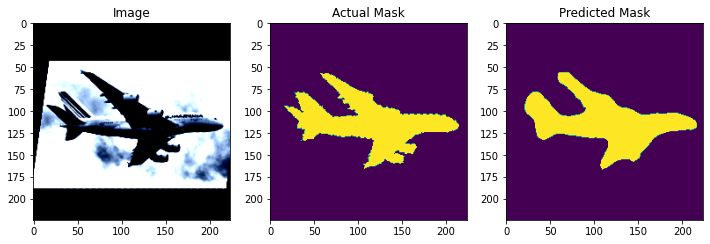

In [38]:
idx = 15

input_tensor, actual_mask = train_dataset[idx]
infer(
    input_tensor=input_tensor.unsqueeze(0).to(device),
    actual_mask=actual_mask,
    figsize=(12, 6),
)

Test: Loss=0.3086 Batch_id=62 Accuracy=86.09: 100%|██████████| 63/63 [00:08<00:00,  7.50it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


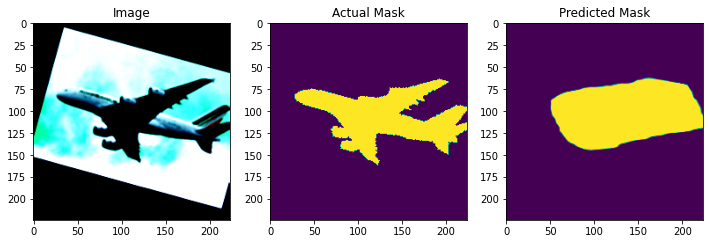

Test: Loss=0.2181 Batch_id=62 Accuracy=90.04: 100%|██████████| 63/63 [00:12<00:00,  4.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


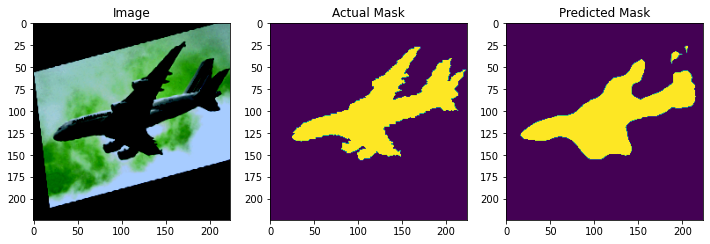

Test: Loss=0.2033 Batch_id=62 Accuracy=90.80: 100%|██████████| 63/63 [00:12<00:00,  4.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


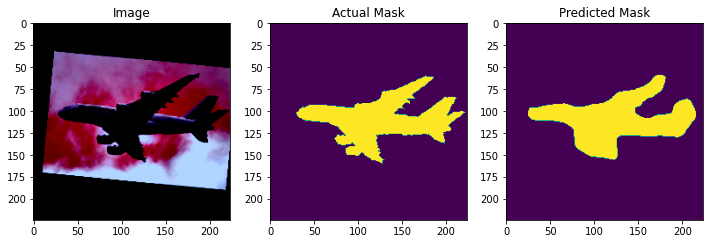

Test: Loss=0.1963 Batch_id=62 Accuracy=91.24: 100%|██████████| 63/63 [00:13<00:00,  4.81it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


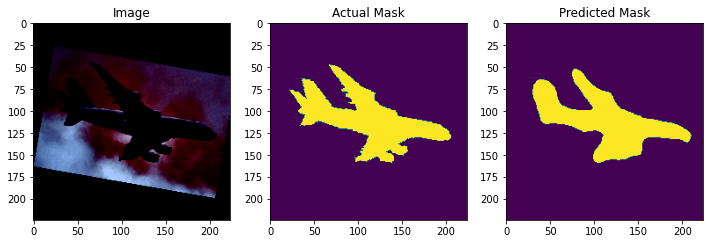

Test: Loss=0.1956 Batch_id=62 Accuracy=91.28: 100%|██████████| 63/63 [00:12<00:00,  4.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


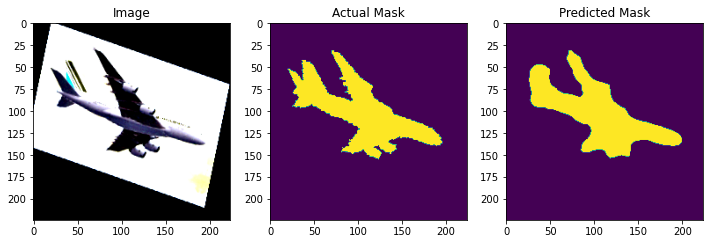

Test: Loss=0.1922 Batch_id=62 Accuracy=91.39: 100%|██████████| 63/63 [00:13<00:00,  4.80it/s]


In [27]:
from tqdm import tqdm


for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, scheduler, device)
    test(model, test_loader, criterion, device)

    if epoch % 10 == 0:
        input_tensor, actual_mask = train_dataset[idx]
        infer(
            input_tensor=input_tensor.unsqueeze(0).to(device),
            actual_mask=actual_mask,
            figsize=(12, 6),
        )

In [40]:
model

UNet(
  (encoder): Encoder(
    (stages): ModuleDict(
      (block1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (block2): Sequential(
        (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

In [39]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    "./binary_segmentation_checkpoint/model.pt",
)

In [41]:
torch.save(
    {
        "decoder_state_dict": model.decoder.state_dict(),
        "output_state_dict": model.output.state_dict(),
    },
    "./binary_segmentation_checkpoint/decoder.pt",
)